## **Setting the Scene**

Imagine you’ve just joined a top tech company — we’ll call it **DataNova**. You’ve been made the lead architect for a new *global analytics platform*. This thing will crunch trillions of rows, power dashboards for 20,000 employees, and run nightly ETL pipelines.

Snowflake is your compute layer. But there’s a catch:
Your CFO is breathing down your neck — *“Keep the cost low!”*.
Your CTO is right behind her — *“Keep the performance high!”*.

The weapon of choice? **Virtual Warehouses**. And your job is to choose the right size, scaling method, and policy.

---

## **1) How would you decide which size of VWH to choose for a new ETL pipeline?**

**Fundamentals first:**
A Snowflake Virtual Warehouse size (`X-Small` → `6X-Large`) controls:

* **Parallelism** — number of threads & degree of parallel query execution.
* **Memory per node** — bigger warehouses = more cache & temp space.
* **Compute power** — affects how fast queries & transformations run.

**Story scenario:**
Let’s say you’re building a **nightly ETL pipeline** that:

1. Reads 500M rows from staging.
2. Transforms them heavily (joins, aggregations, window functions).
3. Loads them into a fact table.

If your pipeline is **CPU-heavy** with complex transformations, a larger size helps.
If it’s mostly **I/O-bound** (just moving data between tables), even an `X-Small` or `Small` might do — scaling size beyond that won’t help much.

**Teacher Tip:** Start *small*, measure run time, scale up if needed. Think of it like ordering coffee: start with a medium; only upgrade to large if you’re still sleepy.

**Decision framework:**

* **Data size small (<100M rows)** → Start `Small` or `Medium`
* **Moderate size (100M–1B rows)** + complex transforms → Start `Large`
* **Very large or performance-critical** → `XL` or above

---

## **2) When is a multi-cluster VWH better than just increasing warehouse size?**

**Scaling up (size)** = Bigger single warehouse. Good for *big single queries*.
**Scaling out (multi-cluster)** = Multiple warehouses running in parallel. Good for *many small queries at once*.

**Story:**
Think of a restaurant.

* **Scaling up**: Get a bigger kitchen to cook one big banquet faster.
* **Scaling out**: Open multiple kitchens so you can serve multiple wedding parties simultaneously.

If your ETL runs **one giant batch job**, scaling up is best.
If you have **dozens of dashboards hitting Snowflake at once**, scaling out prevents queuing.

---

## **3) Scaling up vs Scaling out — When to choose which?**

* **Scaling up:** Single query needs more power (e.g., complex join across billions of rows).
* **Scaling out:** Many queries running in parallel, but each is not huge (e.g., BI dashboards in peak morning hours).

---

## **4) Queued queries during peak hours — Increase size or change scaling policy?**

If queries are queued because **many are running at once**, changing size won’t help — one kitchen still serves one order at a time.
Instead, enable **multi-cluster** so multiple kitchens handle different orders.

If queues are due to **a single query being slow**, then increasing size helps.

---

## **5) Economy scaling policy — Friend or foe?**

* **Standard policy:** Adds clusters *immediately* when queues form; removes them quickly when load drops.
* **Economy policy:** Adds clusters slowly to save cost; removes them slower.

**Economy helps:** For workloads with small spikes — avoids spinning up expensive clusters unnecessarily.
**Hurts performance:** For sudden, huge spikes — you’ll still see queues because scaling is delayed.

---

## **6) min=1, max=5 — What happens?**

1. Start of day: 1 cluster runs.
2. Load increases — if queries queue for >6 seconds, 2nd cluster spins up.
3. Keep adding until max=5 clusters if load continues.
4. As load drops, Snowflake removes clusters one by one.

---

## **7) When does Snowflake "pin" a cluster?**

Snowflake keeps a cluster alive for a few minutes **after load drops** to avoid “thrashing” (rapid start/stop).
Economy policy keeps them alive longer; standard policy removes them faster.

---

## **8) Risks of Maximized Mode in Production**

Maximized mode = all clusters run at max from the start — **no scaling down**.
Risk: If min=max=5 and size=XL, you pay for all 5 XL warehouses 24/7 — even if nobody’s using them.

---

## **9) 4x-Large clusters, min=max=6 — Billing danger**

If you forget to suspend, you’re burning:
`6 clusters × 4XL size × hourly credits`
…and each 4XL burns a lot of credits per hour. This can eat budgets overnight.

---

## **10) Credit usage spikes — Investigation steps**

1. Check **WAREHOUSE\_METERING\_HISTORY** for cluster hours.
2. See if **multi-cluster** maxed out.
3. Review query history for concurrency spikes.
4. Check if Maximized mode was enabled by mistake.
5. Look for forgotten “always-on” warehouses.

---

## **11) Standard vs Snowpark-optimized VWH**

* **Standard:** Balanced for general SQL workloads.
* **Snowpark Optimized:** More memory per node, better for big data science & ML processing.

---

## **12) Cost-efficiency + acceptable latency for nightly batch**

For a predictable nightly batch:

* Use **Standard** scaling.
* `Medium` or `Large` size (start small).
* Auto-suspend after job.
* No need for multi-cluster unless parallel batch streams.

---

## **Extra Topics **

* **Auto-suspend & Auto-resume** → Essential for cost control.
* **Caching effects** → Larger warehouses may not help if query is already served from result cache.
* **Mixing warehouses for workloads** → ETL and BI dashboards should often use different warehouses.
* **Credit burn patterns** → Always monitor after changes.

---


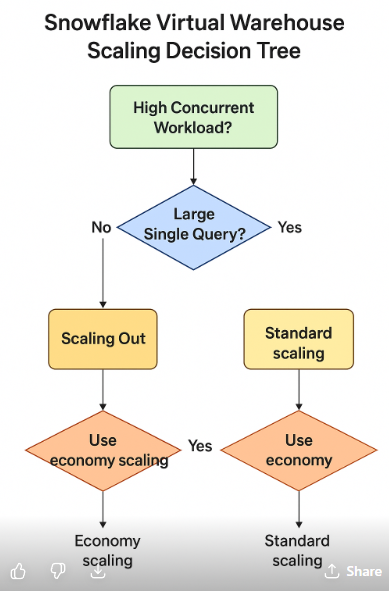


---

## **1. How would you decide between scaling up vs scaling out for a high-concurrency dashboard system?**

**Scaling up** = Make one warehouse bigger. Good when:

* You have **few but very heavy queries** that need more compute/memory.
* Example: A complex monthly financial report joining billions of rows in one go.

**Scaling out** = Add more clusters (multi-cluster). Good when:

* You have **many users hitting the system at the same time**.
* Example: A BI dashboard used by 300 sales reps at 9 AM.

**For a high-concurrency dashboard:**

* Scaling out is better because each concurrent query can be handled by a separate cluster, reducing queuing.
* Size doesn’t help much if queries are already optimized — concurrency is the main bottleneck.

---

## **2. What’s the risk of leaving a large multi-cluster warehouse running over the weekend?**

If `min` is high (e.g., min=5) and warehouse size is large (`XL` or above):

* You pay for **all clusters 24/7**, even when no queries run.
* If auto-suspend is disabled, Snowflake charges continuously in **1-minute increments** per active cluster.
* Example: 5 × XL clusters = **huge credit burn** even if idle.

---

## **3. How would you configure warehouses for ETL vs ad-hoc queries?**

* **ETL workloads**:

  * Predictable timing.
  * Use **larger single warehouse** (scaling up) for heavy batch transformations.
  * Set **auto-suspend** right after ETL completion.
  * Often **no need for multi-cluster** unless running parallel jobs.

* **Ad-hoc queries**:

  * Unpredictable concurrency.
  * Use **multi-cluster small/medium warehouses** to handle sudden spikes.
  * Economy scaling if spikes are small; standard scaling for instant response.

---

## **4. What metrics in Snowflake help you identify warehouse under/over-provisioning?**

* **WAREHOUSE\_METERING\_HISTORY** — shows credits used per warehouse.
* **QUERY\_HISTORY** — check execution time vs queuing time.
* **WAREHOUSE\_LOAD\_HISTORY** — see % of time warehouse was queued, running, or idle.
* **Concurrency scaling activity** (multi-cluster logs) — see how often additional clusters are triggered.

---

## **5. Why might a warehouse upgrade not improve performance for certain queries?**

* Query is **I/O bound**, not CPU bound (bigger warehouse won’t help).
* Query is served from **result cache** (size irrelevant).
* Poor SQL design (unnecessary cross joins, no pruning).
* Table isn’t **clustered** properly → lots of data scanned regardless of size.
* Example: Upgrading from Medium to Large won’t help if the bottleneck is reading from S3 external stage.

---
